In [1]:
import torch
import random
import pandas as pd
import numpy as np
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim

In [2]:
data_dir = 'DATASET'

train_dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

test_dataset = torchvision.datasets.MNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

In [3]:
train_dataset_size = int(0.8 * len(train_dataset))
valid_dataset_size = len(train_dataset) - train_dataset_size

train_data, valid_data = random_split(
    train_dataset,
    [train_dataset_size, valid_dataset_size]
)

In [4]:
batch_size = 256

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

valid_loader = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
)

In [6]:
class Encoder(nn.Module):
    
    def __init__(
        self,
        encoded_space_dim,
        fc2_input_dim
    ):
        super(Encoder, self).__init__()
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3*3*32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim),
        )
    
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

In [7]:
class Decoder(nn.Module):
    
    def __init__(
        self,
        encoded_space_dim,
        fc2_input_dim,
    ):
        super(Decoder, self).__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3*3*32),
            nn.ReLU(True),
        )
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [8]:
torch.manual_seed(47)
loss_func = nn.MSELoss()
lr = 1e-3
depth = 4
encoder = Encoder(encoded_space_dim=depth, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=depth, fc2_input_dim=128)
params_to_optimize = [
    {"params": encoder.parameters()},
    {"params": decoder.parameters()},
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
device = torch.device('mps')

In [9]:
encoder.to(device)

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [10]:
decoder.to(device)

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [11]:
def add_noise(inputs, noise_factor=0.3):
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0.0, 1.0)
    return noisy

In [12]:
def train(
    encoder,
    decoder,
    device,
    dataloader,
    loss_fn,
    optimizer,
    noise_factor=0.3,
):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch, noise_factor)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [13]:
def test(
    encoder,
    decoder,
    device,
    dataloader,
    loss_fn,
    noise_factor=0.3,
):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        outputs = []
        labels = []
        for image_batch, _ in dataloader:
            image_noisy = add_noise(image_batch, noise_factor)
            image_noisy = image_noisy.to(device)
            encoded_data = encoder(image_noisy)
            decoded_data = decoder(encoded_data)
            outputs.append(decoded_data.cpu())
            labels.append(image_batch.cpu())
        outputs = torch.cat(outputs)
        labels = torch.cat(labels)
        val_loss = loss_fn(outputs, labels)
    return val_loss.data

In [14]:
def plot_examples(
    encoder,
    decoder,
    n=10,
    noise_factor=0.3,
):
    plt.figure(figsize=(16, 5))
    targets = test_dataset.targets.numpy()
    t_idx = {i: np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0)
        image_noisy = add_noise(img, noise_factor)
        image_noisy = image_noisy.to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img = decoder(encoder(image_noisy))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        plt.axis('off')
        if i == n/2:
            ax.set_title('original images')
        ax = plt.subplot(3, n, i+1+n)
        plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
        plt.axis('off')
        if i == n // 2:
            ax.set_title('corrupted images')
        ax = plt.subplot(3, n, i+1+n+n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        plt.axis('off')
        if i == n // 2:
            ax.set_title('reconstructed images')
    plt.show()


EPOCH: 1/30
train loss: 0.1393669843673706
valid loss: 0.07043735682964325


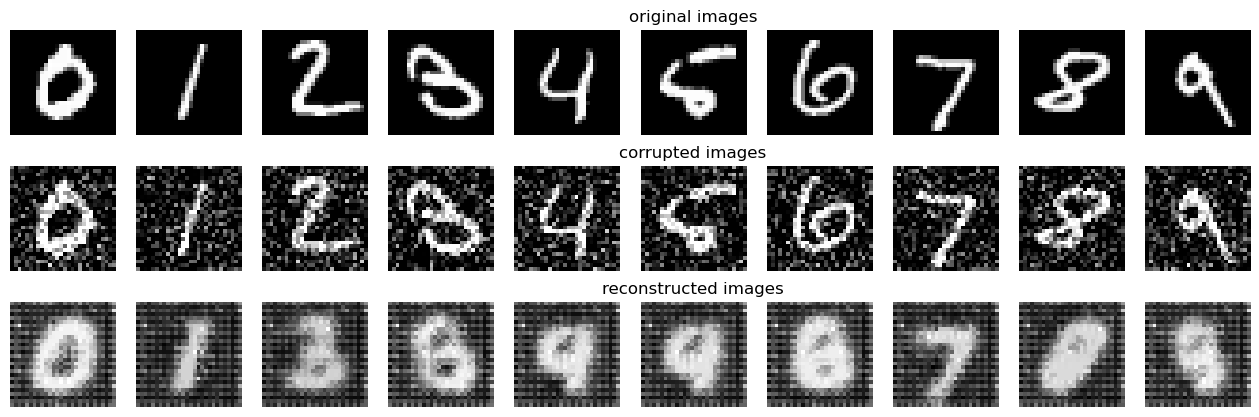


EPOCH: 2/30
train loss: 0.05542315915226936
valid loss: 0.048285163938999176


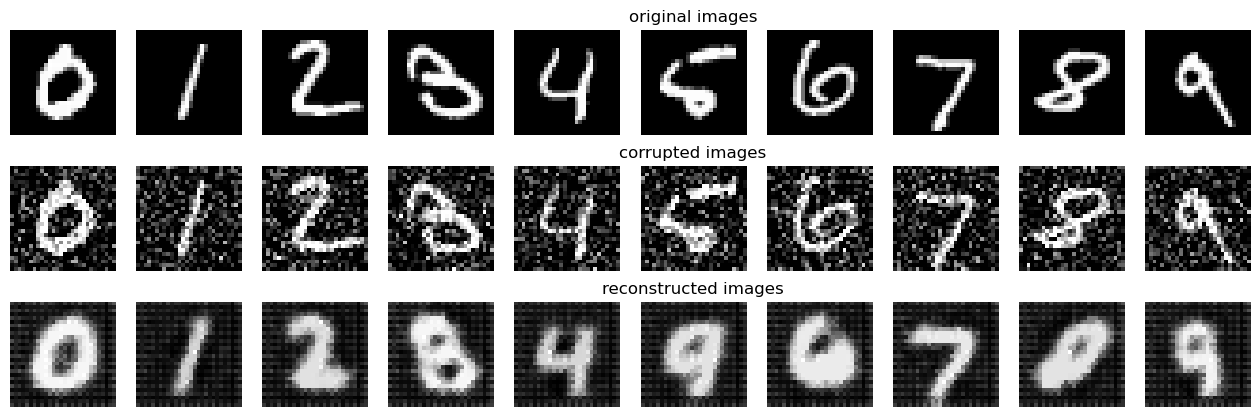


EPOCH: 3/30
train loss: 0.045466888695955276
valid loss: 0.04385875537991524


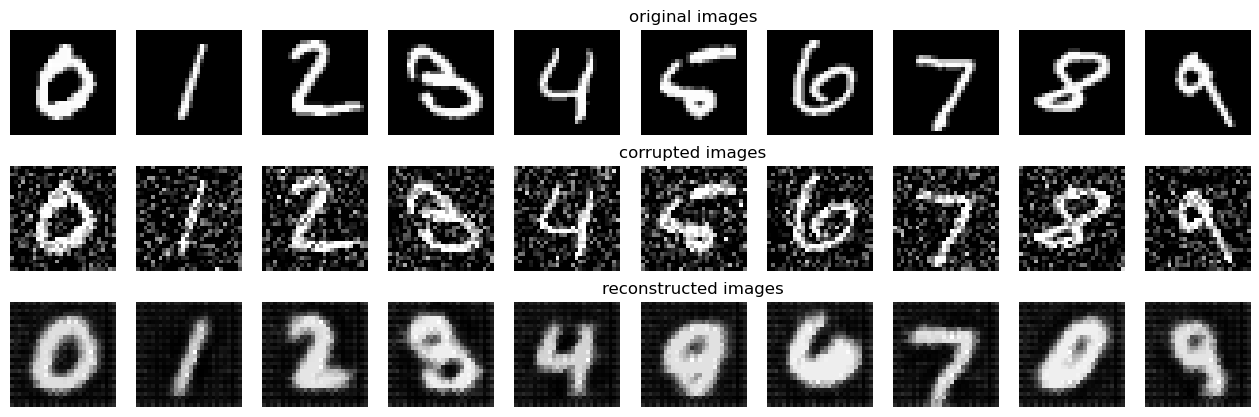


EPOCH: 4/30
train loss: 0.04249083250761032
valid loss: 0.041815076023340225


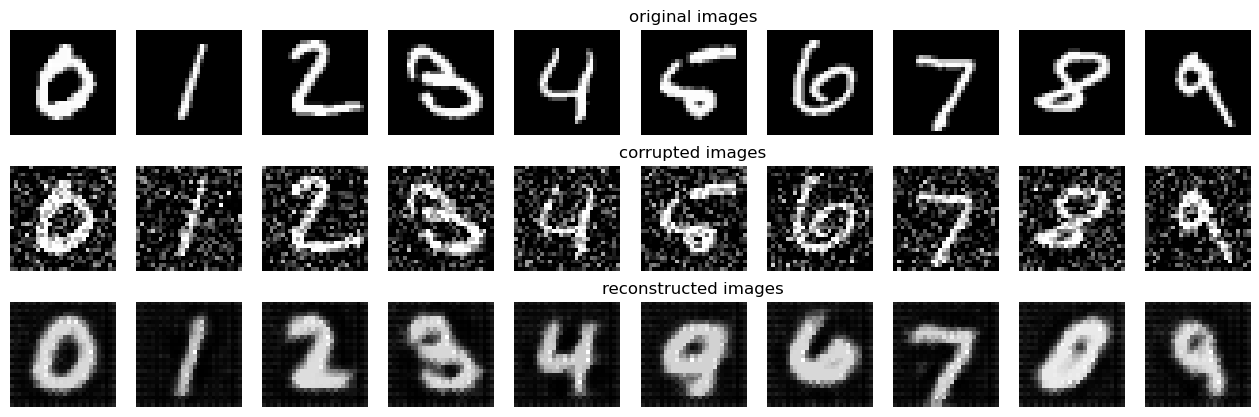


EPOCH: 5/30
train loss: 0.040683068335056305
valid loss: 0.04019785299897194


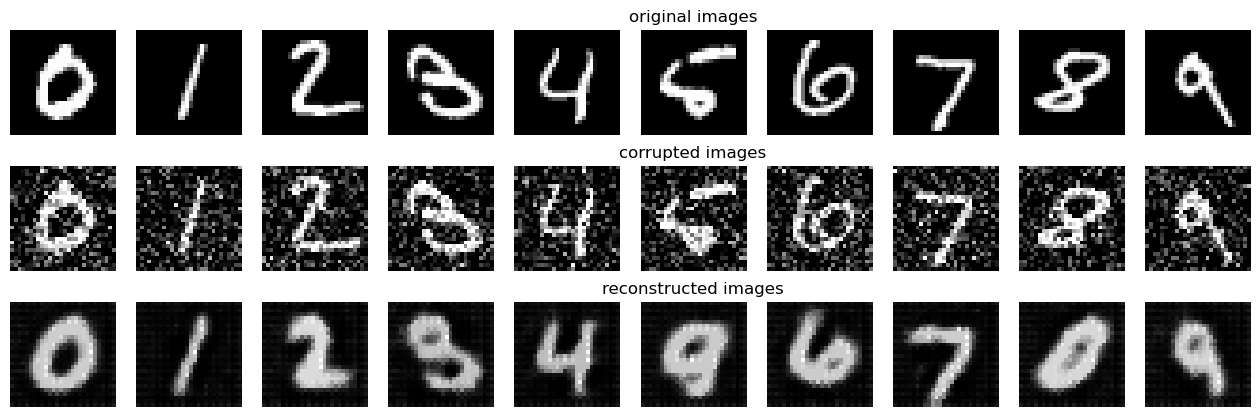


EPOCH: 6/30
train loss: 0.03918119892477989
valid loss: 0.038804326206445694


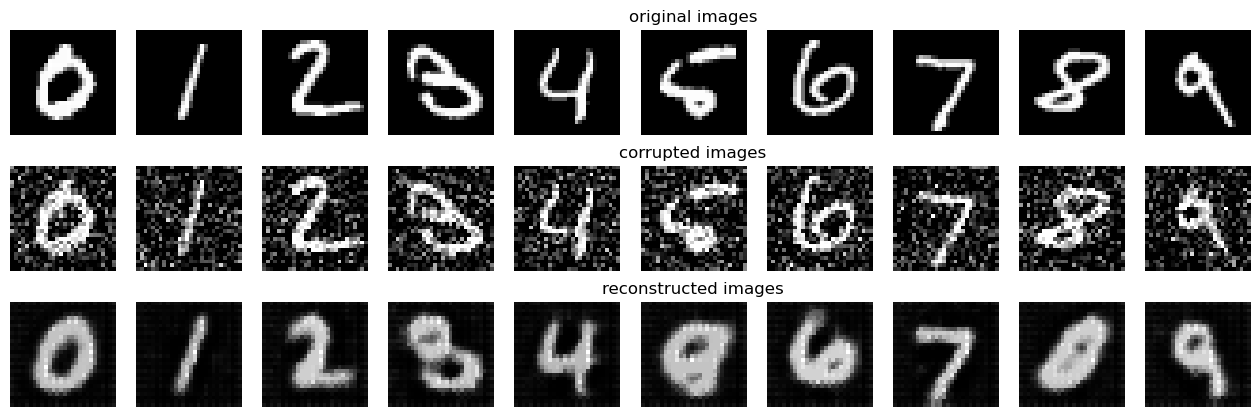


EPOCH: 7/30
train loss: 0.037801750004291534
valid loss: 0.0375487245619297


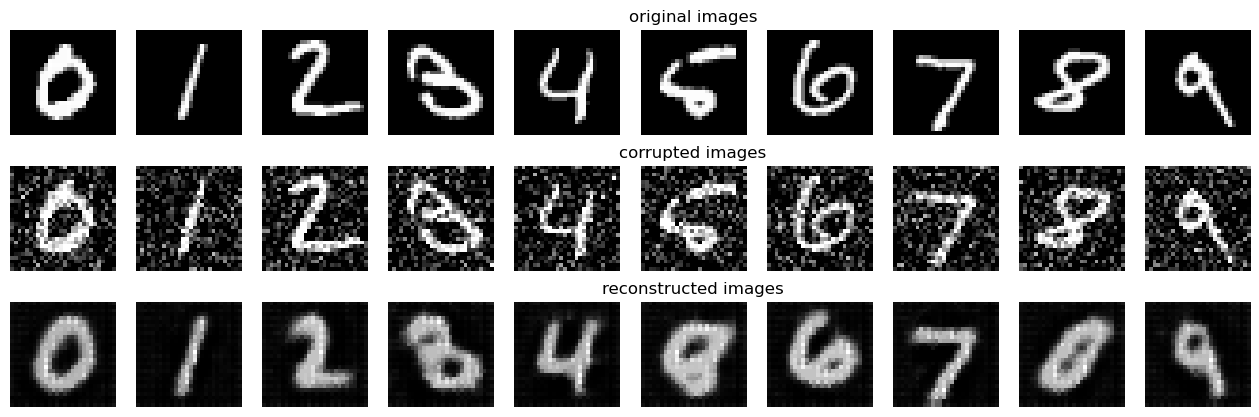


EPOCH: 8/30
train loss: 0.036560844630002975
valid loss: 0.03633054345846176


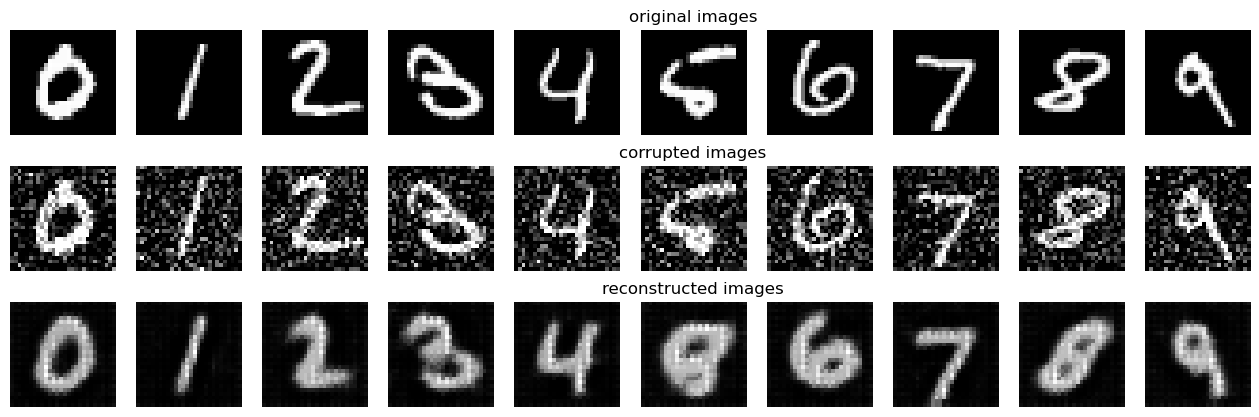


EPOCH: 9/30
train loss: 0.035200320184230804
valid loss: 0.03481745347380638


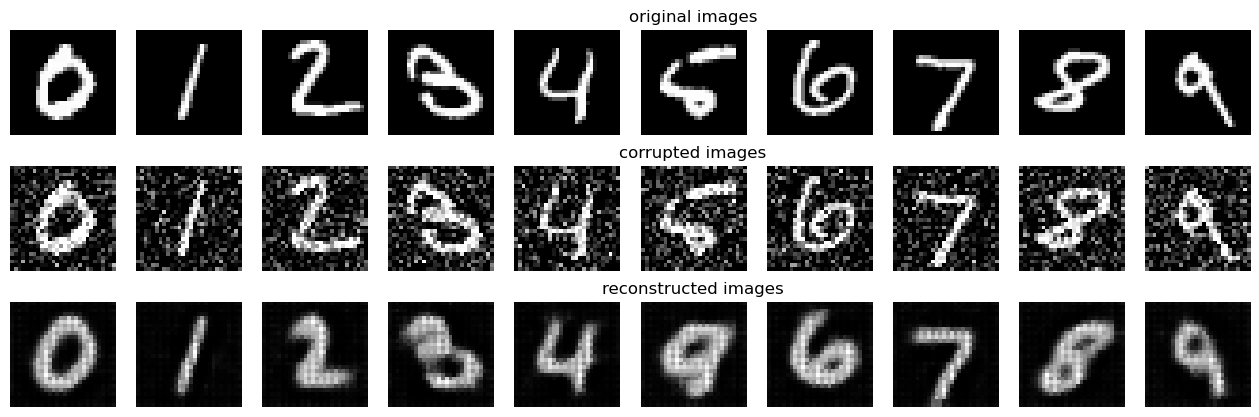


EPOCH: 10/30
train loss: 0.033520400524139404
valid loss: 0.032840415835380554


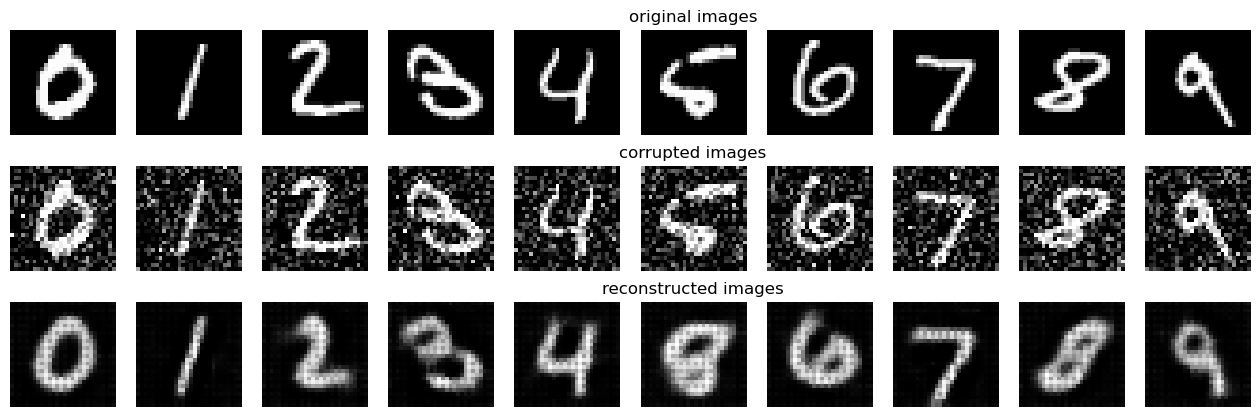


EPOCH: 11/30
train loss: 0.031553853303194046
valid loss: 0.031139248982071877


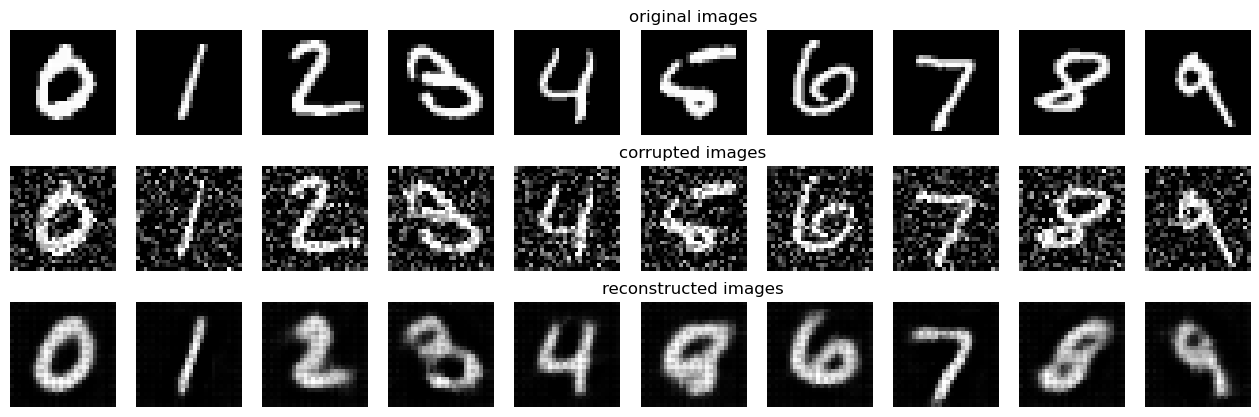


EPOCH: 12/30
train loss: 0.03031175397336483
valid loss: 0.030473865568637848


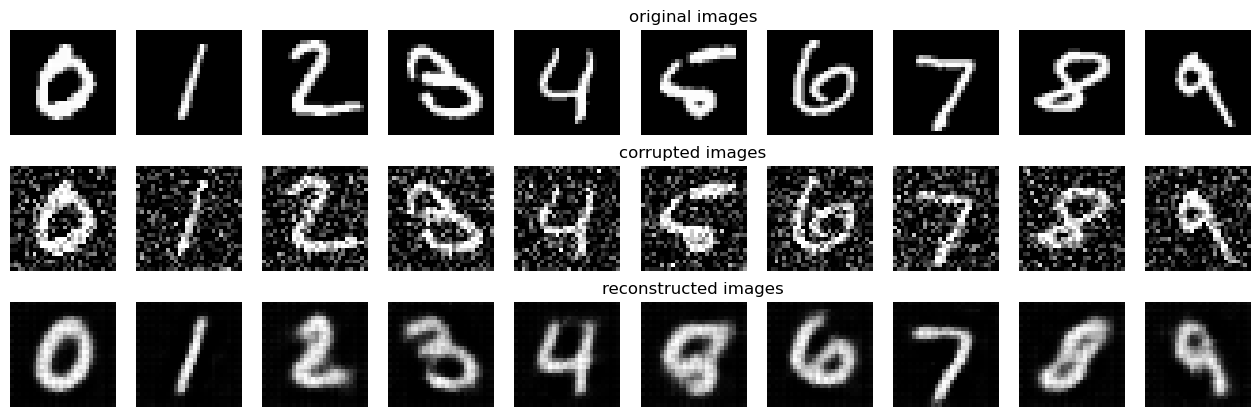


EPOCH: 13/30
train loss: 0.029666664078831673
valid loss: 0.029862215742468834


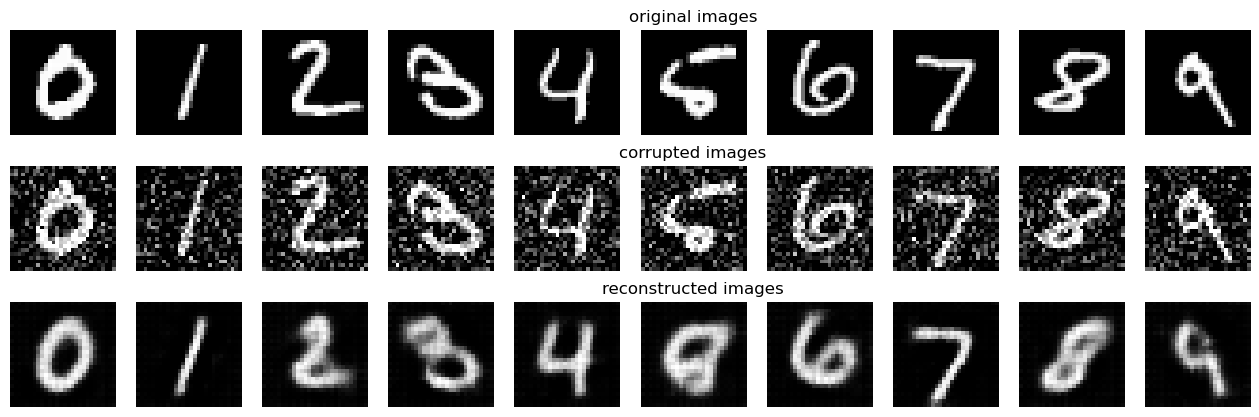


EPOCH: 14/30
train loss: 0.029220398515462875
valid loss: 0.02941713109612465


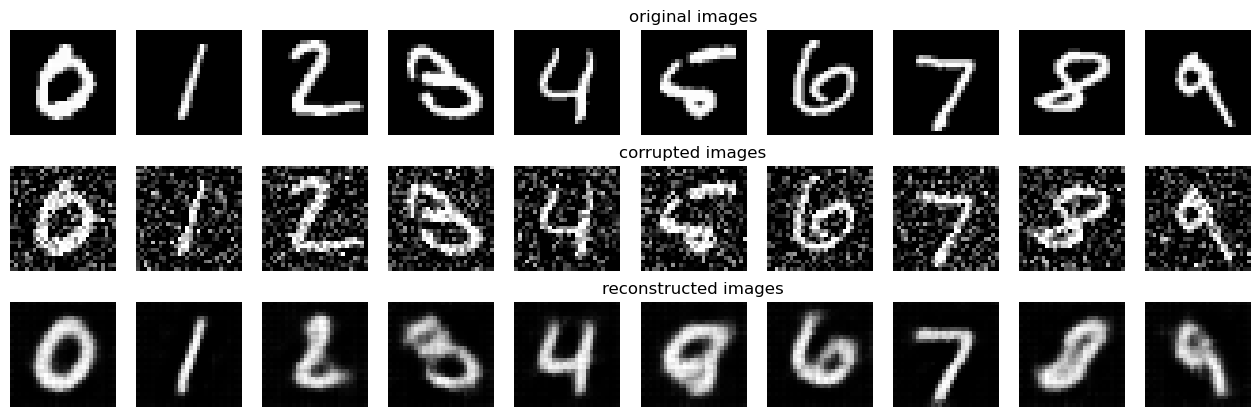


EPOCH: 15/30
train loss: 0.028860989958047867
valid loss: 0.029148507863283157


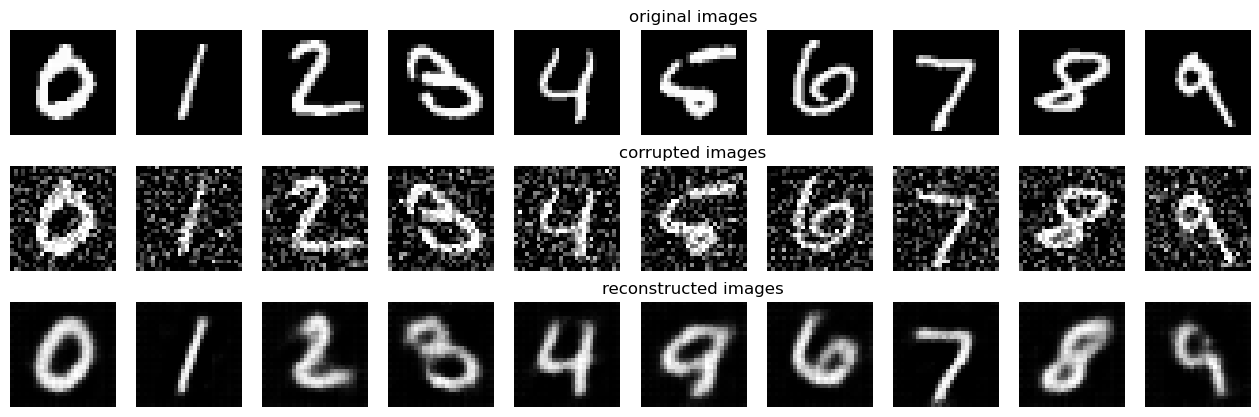


EPOCH: 16/30
train loss: 0.028548210859298706
valid loss: 0.029132507741451263


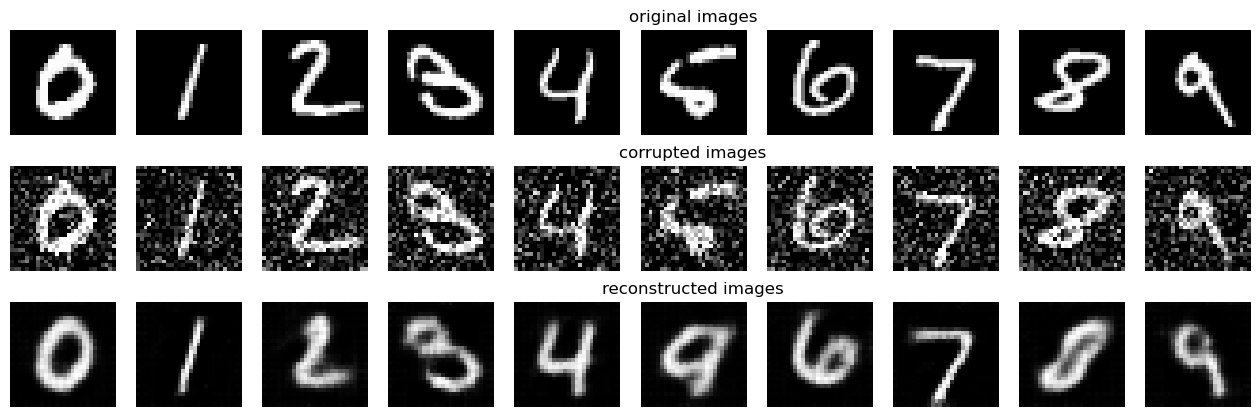


EPOCH: 17/30
train loss: 0.028375858440995216
valid loss: 0.0287050511687994


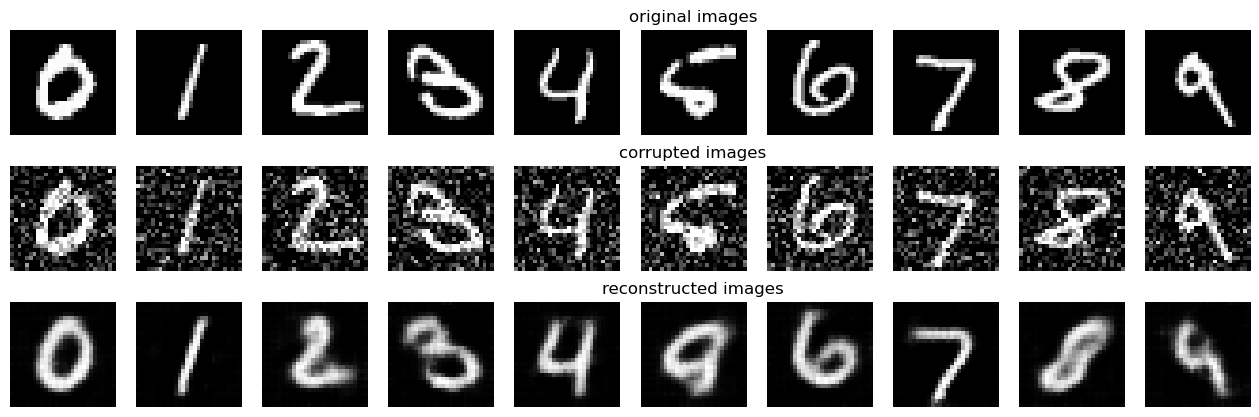


EPOCH: 18/30
train loss: 0.028161490336060524
valid loss: 0.0287666954100132


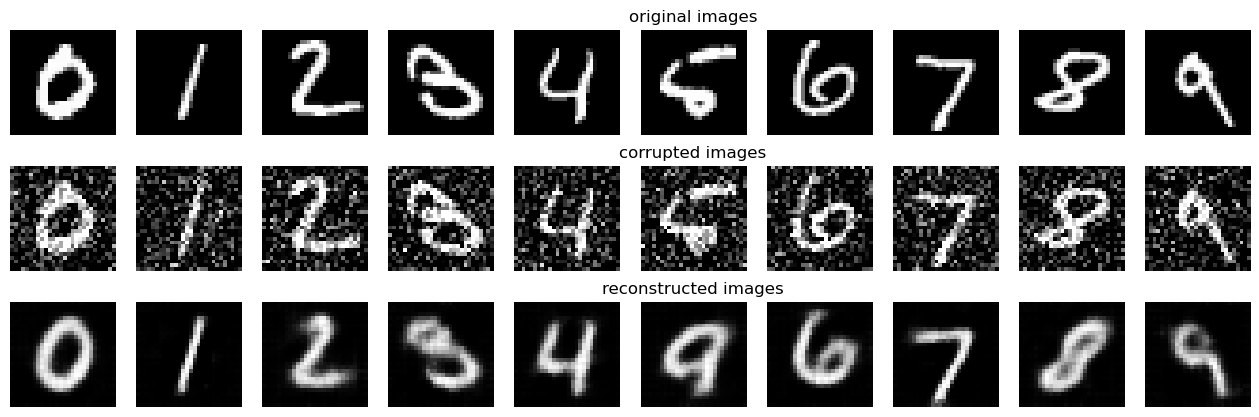


EPOCH: 19/30
train loss: 0.02797740511596203
valid loss: 0.028312886133790016


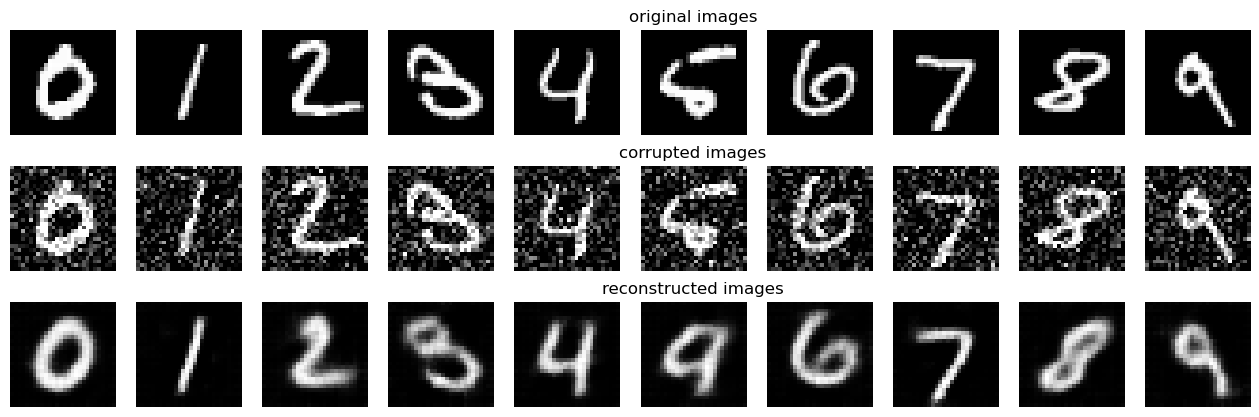


EPOCH: 20/30
train loss: 0.02783718705177307
valid loss: 0.028440000489354134


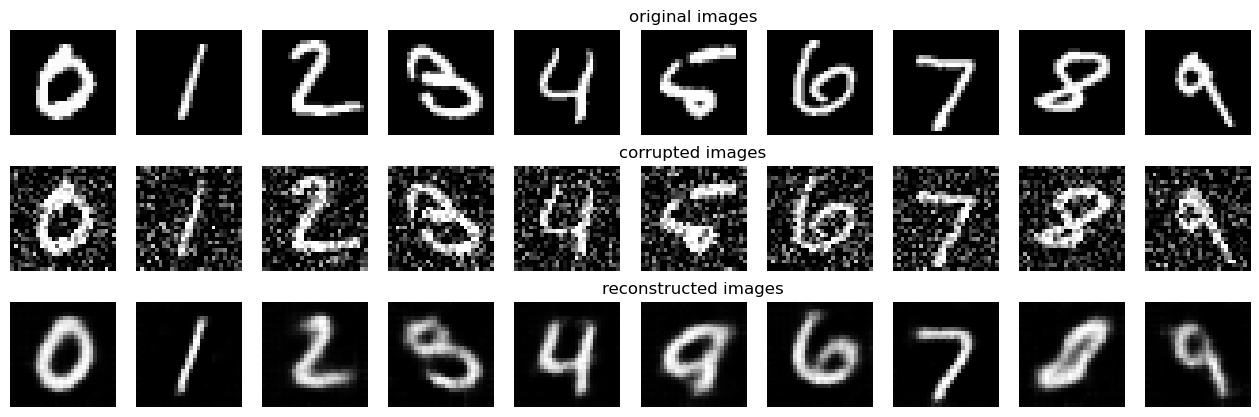


EPOCH: 21/30
train loss: 0.027695488184690475
valid loss: 0.028193628415465355


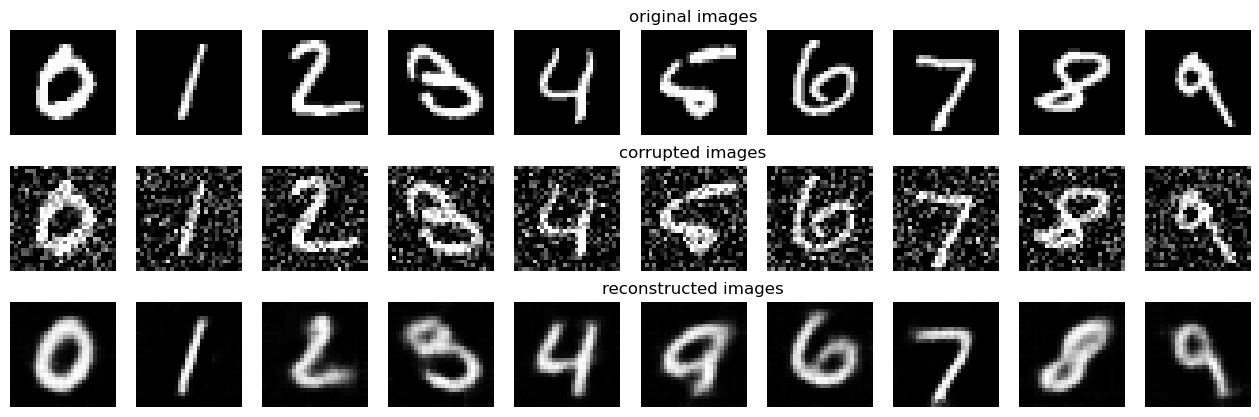


EPOCH: 22/30
train loss: 0.02759295515716076
valid loss: 0.028184574097394943


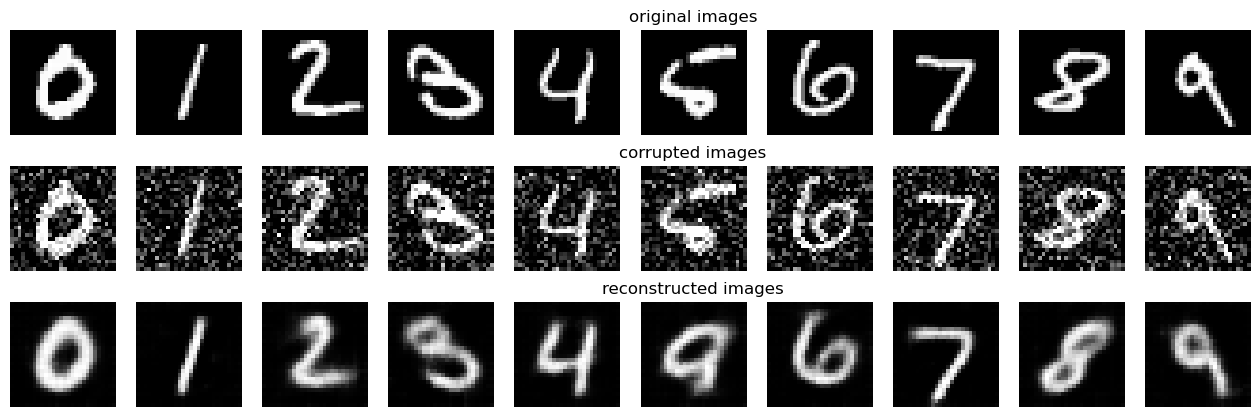


EPOCH: 23/30
train loss: 0.02745438553392887
valid loss: 0.02787184715270996


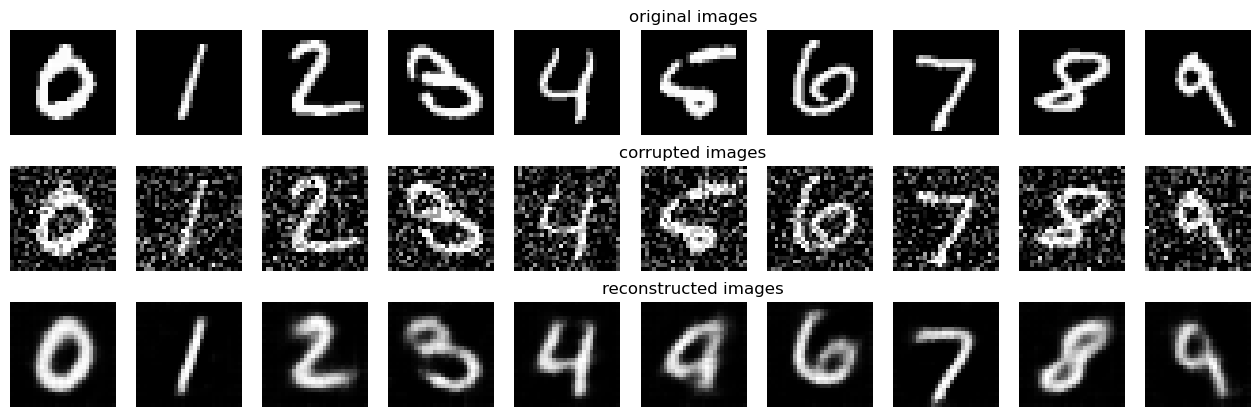


EPOCH: 24/30
train loss: 0.02731749787926674
valid loss: 0.02800355665385723


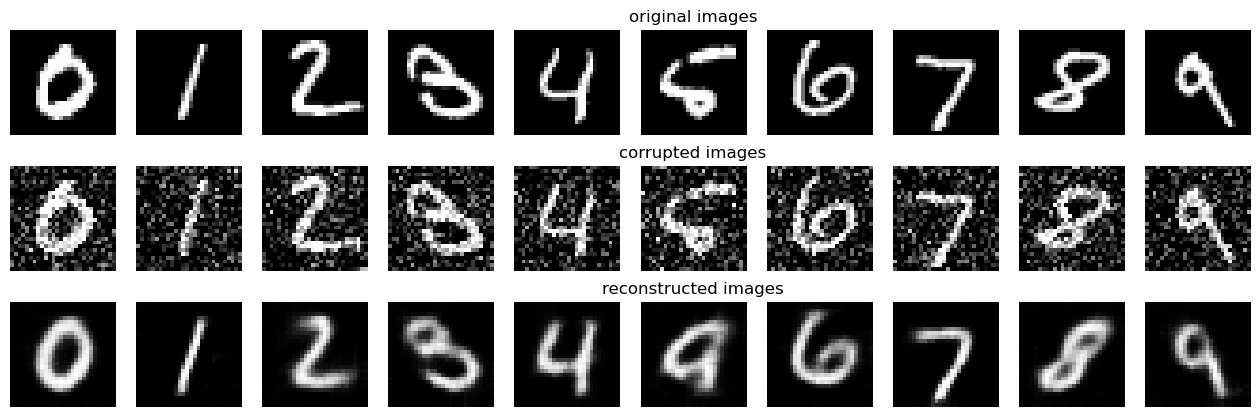


EPOCH: 25/30
train loss: 0.02723119780421257
valid loss: 0.02768586575984955


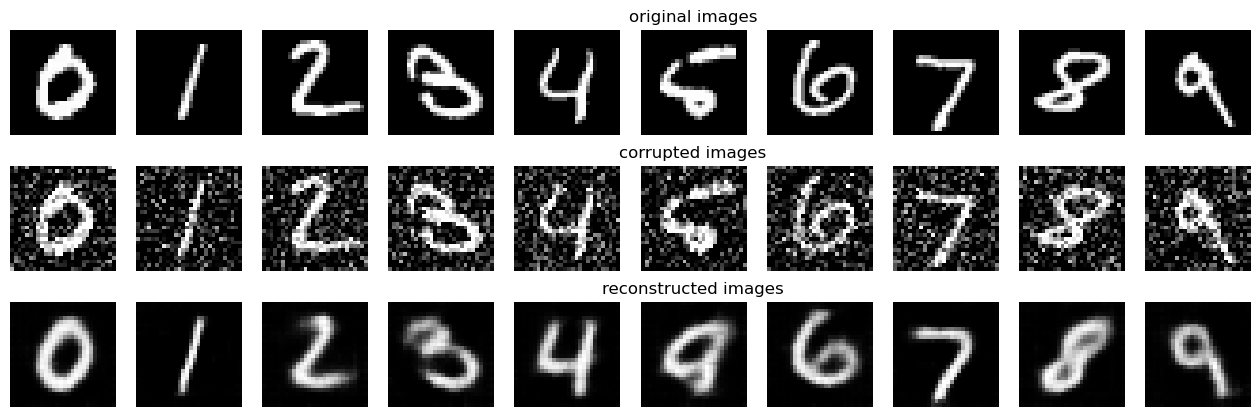


EPOCH: 26/30
train loss: 0.027165714651346207
valid loss: 0.02765600010752678


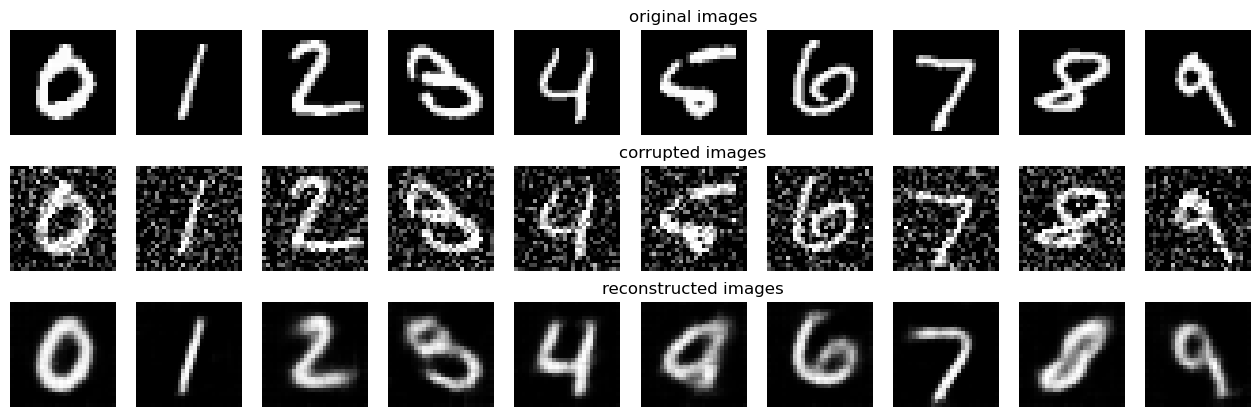


EPOCH: 27/30
train loss: 0.027044301852583885
valid loss: 0.027545396238565445


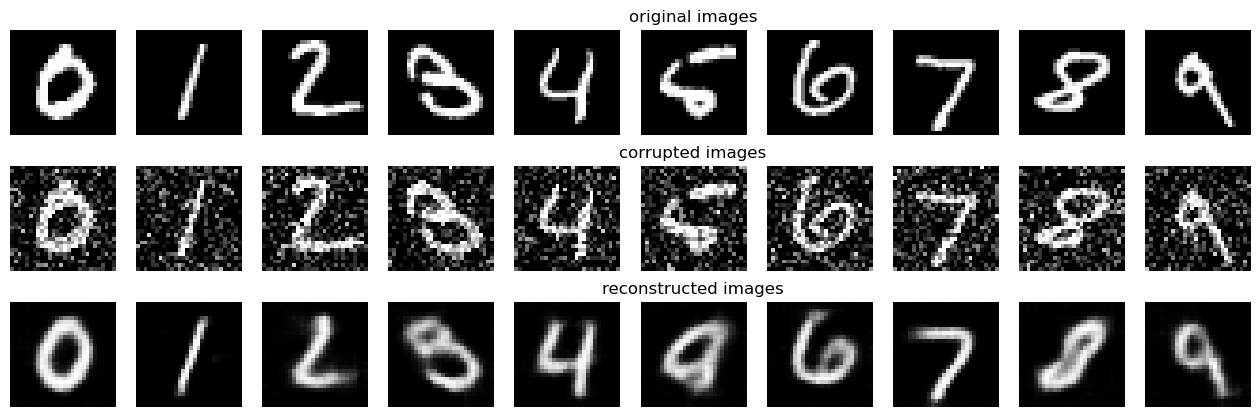


EPOCH: 28/30
train loss: 0.026936767622828484
valid loss: 0.02765345387160778


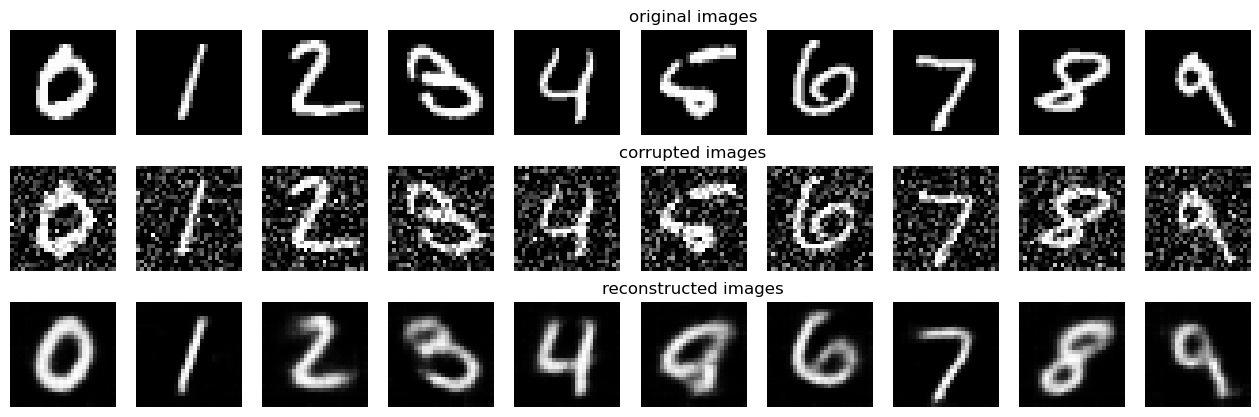


EPOCH: 29/30
train loss: 0.02688523568212986
valid loss: 0.027610065415501595


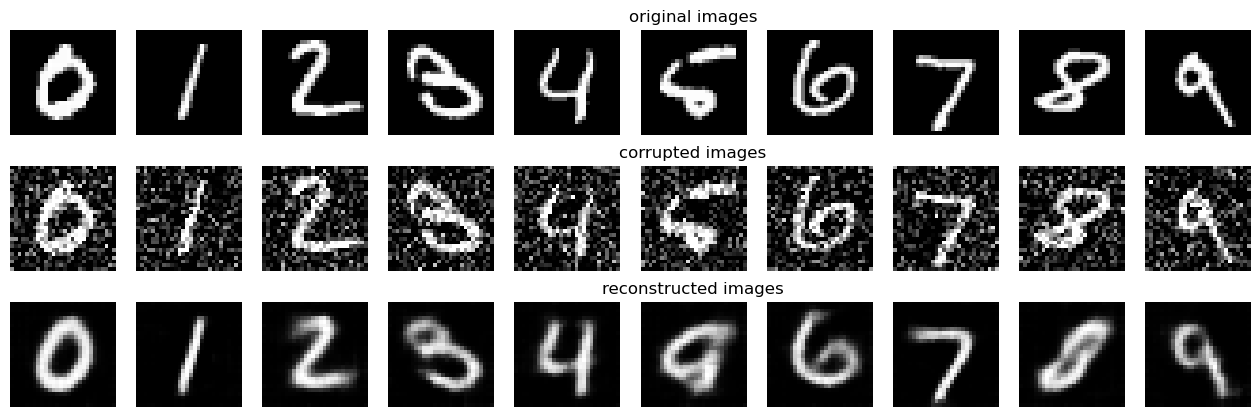


EPOCH: 30/30
train loss: 0.026840975508093834
valid loss: 0.02733440324664116


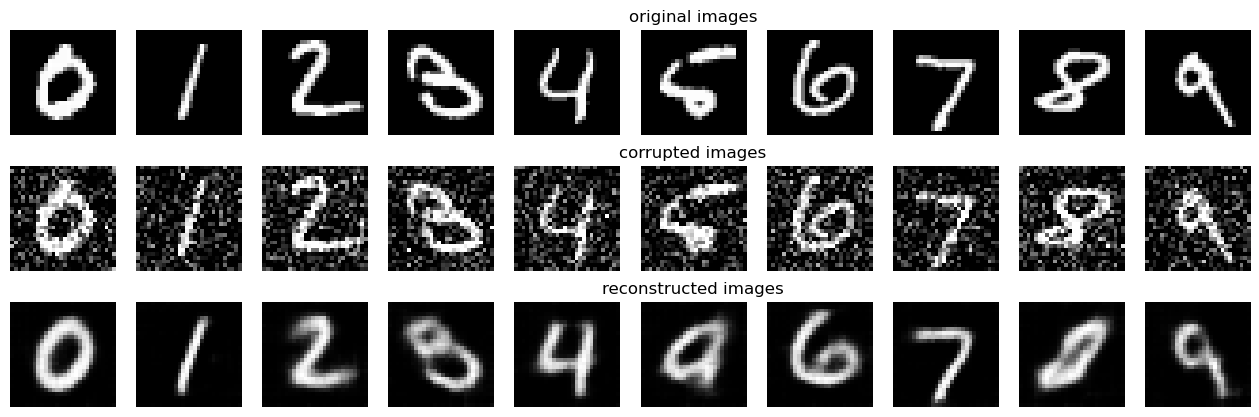

In [16]:
num_epochs = 30
noise_factor = 0.3
history_data = {'train_loss': [], 'valid_loss': []}

for epoch in range(num_epochs):
    print(f'\nEPOCH: {epoch+1}/{num_epochs}')
    train_loss = train(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=train_loader,
        loss_fn=loss_func,
        optimizer=optim,
        noise_factor=noise_factor,
    )
    valid_loss = test(
        encoder=encoder,
        decoder=decoder,
        device=device,
        dataloader=valid_loader,
        loss_fn=loss_func,
        noise_factor=noise_factor,
    )
    history_data['train_loss'].append(train_loss)
    history_data['valid_loss'].append(valid_loss)
    print(f'train loss: {train_loss}')
    print(f'valid loss: {valid_loss}')
    plot_examples(encoder, decoder, n=10, noise_factor=noise_factor)